In [23]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.classes.function import info
from networkx.drawing.layout import spring_layout
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import HTML
import warnings
warnings.simplefilter('ignore')

%matplotlib notebook

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Нажмите чтобы отобразить/скрыть код."></form>''')

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


# Задача о максимальном потоке

## Постановка задачи о максимальном потоке

<br>&#8195;&#8195;Задача о максимальном потоке заключается в нахождении такого потока по транспортной сети,
что сумма потоков из истока, или, что то же самое, сумма потоков в сток максимальна.
     
<br>&#8195;&#8195;Рассмотрим сеть, имеющую только один источник s и только один сток t. Рассмотрим задачу о
потоке из узла s в узел t, причем s и t могут быть связаны произвольно сложной промежуточной сетью.
Задача о максимальном потоке состоит в определении количества, которое можно перевезти из s в t.
## Основные понятия
<br>&#8195;&#8195;Сетью (flow network) называется ориентированный граф, каждому ребру (i,j) которого сопоставлено неотрицательное число C(i,j), называемое пропускной способностью, с двумя выделенными вершинами,
называемыми исток s (source) и сток t (sink).
Необходимо знать следующие правила для решения задачи.
1. Будем считать, что если поток из вершины i к j равен $\varphi_{ij}$ , то противоположный поток равен -$\varphi_{ij}$.
2. Если поток по дуге $\varphi_{ij}$ меньше его пропускной способности, то есть $\varphi_{ij}<C_{ij}$ , то дуга называется ненасыщенной потоком, если же $\varphi_{ij}=C_{ij}$ , то дуга называется насыщенной потоком.
3. Из физического смысла грузопотока следует, что поток по каждой дуге не может превышать ее пропускную способность, т.е. $\varphi_{ij} \leq C_{ij}$.
4. Для любой вершины, кроме источника и стока, количество вещества, поступающего в эту вершину, равно количеству вещества, вытекающего из него. Это условие называется условием сохранения потока, в промежуточных вершинах потоки не создаются и не исчезают – отсюда следует, что общее количество вещества, вытекающего из источника, совпадает с общим количеством вещества, поступающего в сток.

In [24]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.flow.utils import *
__all__ = ['edmonds_karp']

def edmonds_karp_core(R, s, t, cutoff,G):
    """Implementation of the Edmonds-Karp algorithm.
    """
    R_nodes = R.nodes
    R_pred = R.pred
    R_succ = R.succ

    inf = R.graph['inf']

    def augment(path, G):
        """Augment flow along a path from s to t.
        """
        # Determine the path residual capacity.
        flow = inf
        it = iter(path)
        u = next(it)
        for v in it:
            attr = R_succ[u][v]  
            flow = min(flow, attr['capacity'] - attr['flow'])
            u = v
        if flow * 2 > inf:
            raise nx.NetworkXUnbounded(
                'Infinite capacity path, flow unbounded above.')
        # Augment flow along the path.
        it = iter(path)
        #### Путь для итерации и флеу
        #print("Path: ",path,"Flow: ",flow)
        listofpath.append(path)
        
        flow_s ="f = "+str(flow)
        i = 0
        
        u = next(it)
        #### Добавление флоу к edge R
        for v in it:
            R_succ[u][v]['flow'] += flow
            R_succ[v][u]['flow'] -= flow
            u = v
        nx.add_path(G,path)
        #### КОНКАТЕНАЦИЯ СЛОВАРЕЙ
        x = nx.get_edge_attributes(G,'labels')
        y = nx.get_edge_attributes(R,'flow')
        for key in x:
            x[key] = x[key]+'ϕ: '+str(y[key])
        listofflow.append(x)
        flowlist.append(flow)
        ####
        return flow

    def bidirectional_bfs():
        """Bidirectional breadth-first search for an augmenting path.
        """
        pred = {s: None}
        q_s = [s]
        succ = {t: None}
        q_t = [t]
        while True:
            q = []
            if len(q_s) <= len(q_t):
                for u in q_s:
                    for v, attr in R_succ[u].items():
                        if v not in pred and attr['flow'] < attr['capacity']:
                            pred[v] = u
                            if v in succ:
                                return v, pred, succ
                            q.append(v)
                if not q:
                    return None, None, None
                q_s = q
            else:
                for u in q_t:
                    for v, attr in R_pred[u].items():
                        if v not in succ and attr['flow'] < attr['capacity']:
                            succ[v] = u
                            if v in pred:
                                return v, pred, succ
                            q.append(v)
                if not q:
                    return None, None, None
                q_t = q

    # Look for shortest augmenting paths using breadth-first search.
    flow_value = 0
    while flow_value < cutoff:
        v, pred, succ = bidirectional_bfs()
        if pred is None:
            break
        path = [v]
        # Trace a path from s to v.
        u = v
        while u != s:
            u = pred[u]
            path.append(u)
        path.reverse()
        # Trace a path from v to t.
        u = v
        while u != t:
            u = succ[u]
            path.append(u)
        flow_value += augment(path,G)

    return flow_value


def edmonds_karp_impl(G, s, t, capacity, residual, cutoff):
    """Implementation of the Edmonds-Karp algorithm.
    """
    if s not in G:
        raise nx.NetworkXError('node %s not in graph' % str(s))
    if t not in G:
        raise nx.NetworkXError('node %s not in graph' % str(t))
    if s == t:
        raise nx.NetworkXError('source and sink are the same node')

    if residual is None:
        R = build_residual_network(G, capacity)
    else:
        R = residual

    # Initialize/reset the residual network.
    for u in R:
        for e in R[u].values():
            e['flow'] = 0

    if cutoff is None:
        cutoff = float('inf')
    R.graph['flow_value'] = edmonds_karp_core(R, s, t, cutoff,G)

    return R
    
def edmonds_karp2(G, s, t, capacity='capacity', residual=None, value_only=False,cutoff=None):
    R = edmonds_karp_impl(G, s, t, capacity, residual, cutoff)
    R.graph['algorithm'] = 'edmonds_karp'
    return R

In [25]:
G = nx.DiGraph()
for i in range(1,8):
    G.add_node(i)
G.add_edge(1, 2, labels="C: 20\n", capacity=20)
G.add_edge(1, 3, labels="C: 22\n", capacity=22)
G.add_edge(2, 3, labels="C: 13\n", capacity=13)
G.add_edge(2, 4, labels="C: 8\n", capacity=8)
G.add_edge(2, 5, labels="C: 11\n", capacity=11)
G.add_edge(3, 4, labels="C: 15\n", capacity=15)
G.add_edge(3, 6, labels="C: 16\n", capacity=16)
G.add_edge(4, 5, labels="C: 12\n", capacity=12)
G.add_edge(4, 6, labels="C: 8\n", capacity=8)
G.add_edge(4, 7, labels="C: 17\n", capacity=17)
G.add_edge(5, 7, labels="C: 15\n", capacity=15)
G.add_edge(6, 7, labels="C: 22\n", capacity=22)
C = nx.DiGraph()
def add_nodes(n):
    if(len(list(C.nodes))!=0):
        for i in range(len(list(C.nodes)),len(list(C.nodes))+1+n):
            C.add_node(i)
    else:
        for i in range(len(list(C.nodes))+1,len(list(C.nodes))+n+1):
            C.add_node(i)

<IPython.core.display.Javascript object>


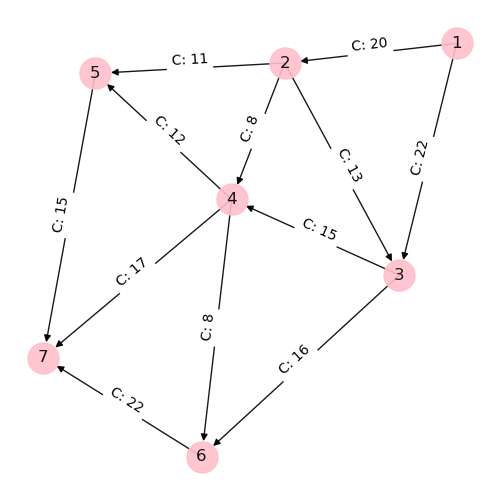

Text(value='', placeholder='Начало дуги')

Text(value='', placeholder='Конец дуги')

Text(value='', placeholder='Пропускная способность')

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [26]:
from networkx.drawing.layout import spring_layout
#### виджеты на добавление связи
a = widgets.Text(placeholder='Начало дуги',description='',disabled=False)
b = widgets.Text(placeholder='Конец дуги',description='',disabled=False)
c = widgets.Text(placeholder='Пропускная способность',description='',disabled=False)
####
#### построение графа
pos = nx.spring_layout(G)
plt.figure(figsize=(5,5))
labels = nx.get_edge_attributes(G,'labels')
nx.draw(G,pos,edge_color='black',width=1,linewidths=1,node_size=500,node_color='pink',alpha=0.9,labels={node:node for node in G.nodes()})
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_color='black')
plt.show()
####
display(a,b,c)
def on_button_clicked():
    x = int(a.value)
    y = int(b.value)
    z = int(c.value)
    a.value = ""
    b.value = ""
    c.value = ""
    G.add_edge(x, y, labels="C: %i\n"%z, capacity=z)
    labels = nx.get_edge_attributes(G,'labels')
    nx.draw(G,pos,edge_color='black',width=1,linewidths=1,node_size=500,node_color='pink',alpha=0.9,labels={node:node for node in G.nodes()})
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_color='black')
    print("Добавлено")
    plt.show()
    
im = widgets.interact_manual(on_button_clicked);
im.widget.children[0].description = 'Добавить'
plt.show()

Результат: 


<IPython.core.display.Javascript object>


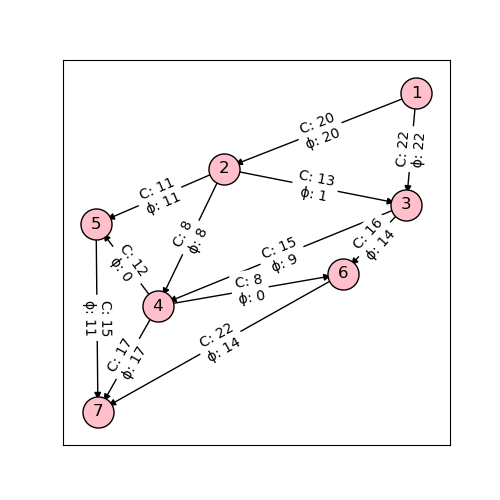

Максимальный поток для сети: 42


In [27]:
%matplotlib notebook
#нахождение максимального потока
listofpath = []
listofflow = []
flowlist = []
R = edmonds_karp2(G,1,7)
####
pos = nx.spring_layout(G)
print("Результат: ")
fig = plt.figure(figsize=(5,5))
all_nodes=nx.draw_networkx_nodes(G,pos,node_size=500,node_color='pink',alpha=1,font_color='black',nodelist={node:node for node in G.nodes()},labels={node:node for node in G.nodes()})
all_edges=nx.draw_networkx_edges(G,pos,edge_color='black',width=1,linewidths=1)
all_labels=nx.draw_networkx_labels(G,pos=pos)
all_nodes.set_edgecolor("black")
nx.draw_networkx_edge_labels(G,pos,edge_labels=listofflow[len(listofflow)-1],font_color='black')
plt.show()
print("Максимальный поток для сети: "+str(R.graph['flow_value']))

## Алгоритм Форда-Фалкерсона нахождения максимального потока
1. Обнуляем все потоки.
2. В сети находим любой путь из источника в сток. Если такого пути нет, останавливаемся.
3. Пускаем через найденный путь максимально возможный поток:
    - На найденном пути в остаточной сети ищем ребро с минимальной пропускной способностью 
    $C_{min}$.<br> 
    ($\beta$=min $C_{ij}$>0)
    - Для каждого ребра на найденном пути увеличиваем поток на $C_{min}$, а в противоположном ему — уменьшаем на $C_{min}$.<br>
    ($\varphi_{ij}$=$\varphi_{ij} \pm C_{min}$)
    - Модифицируем остаточную сеть. Для всех рёбер на найденном пути, а также для противоположных им рёбер, вычисляем новую пропускную способность. Если она стала ненулевой, добавляем ребро к остаточной сети, а если обнулилась, стираем его.<br> 
    ($C_{ij}$=$C_{ij}$-$C_{min}$)
4. Возвращаемся на шаг 2.
<br>Величина максимального потока в транспортной сети T равна минимальной из пропускных способностей
его сечений

In [28]:
from networkx.drawing.layout import spring_layout
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import matplotlib.animation
pos = nx.spring_layout(G)
fig,ax = plt.subplots(figsize=(5,5))
def animate(i):
    ax.clear()
    #print("Path n:"+i)
    cur_path=listofpath[i]
    labels=listofflow[i]
    ax.set_title("Шаг %d:    "%(i+1)+"Путь: %s"%(str(cur_path)), fontweight="bold")
    
    all_nodes=nx.draw_networkx_nodes(G,pos,node_size=500,node_color='white',alpha=1,font_color='black',nodelist={node:node for node in G.nodes()-cur_path},labels={node:node for node in G.nodes()},ax=ax)
    all_edges=nx.draw_networkx_edges(G,pos,edge_color='black',width=1,linewidths=1,ax=ax)
    all_labels=nx.draw_networkx_labels(G,pos=pos,ax=ax)
    all_nodes.set_edgecolor("black")
    path_nodes=nx.draw_networkx_nodes(G,pos,node_size=500,node_color='pink',alpha=1,font_color='black',nodelist={node:node for node in cur_path},labels={node:node for node in cur_path},ax=ax)
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_color='black',ax=ax)
    path_nodes.set_color('pink')
    path_nodes.set_edgecolor("black")
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(listofpath), interval=2000, repeat=True)
plt.show()

<IPython.core.display.Javascript object>

In [12]:
# # Create Graph
# np.random.seed(2)
# Z = nx.cubical_graph()
# Z = nx.relabel_nodes(Z, {0:"O", 1:"X", 2:"XZ", 3:"Z", 4:"Y", 5:"YZ", 6: "XYZ", 7:"XY"})
# pos = nx.spring_layout(Z)

# # Sequence of letters
# sequence_of_letters = "".join(['X', 'Y', 'Z', 'Y', 'Y', 'Z'])
# idx_colors = sns.cubehelix_palette(5, start=.5, rot=-.75)[::-1]
# idx_weights = [3,2,1]

# # Build plot
# fig, ax = plt.subplots(figsize=(6,4))


# def update(num):
#     ax.clear()
#     i = num // 3
#     j = num % 3 + 1
#     triad = sequence_of_letters[i:i+3]
#     path = ["O"] + ["".join(sorted(set(triad[:k + 1]))) for k in range(j)]

#     # Background nodes
#     nx.draw_networkx_edges(Z, pos=pos, ax=ax, edge_color="gray")
#     null_nodes = nx.draw_networkx_nodes(Z, pos=pos, nodelist=set(Z.nodes()) - set(path), node_color="white",  ax=ax)
#     null_nodes.set_edgecolor("black")

#     # Query nodes
#     query_nodes = nx.draw_networkx_nodes(Z, pos=pos, nodelist=path, node_color=idx_colors[:len(path)], ax=ax)
#     query_nodes.set_edgecolor("white")
#     nx.draw_networkx_labels(Z, pos=pos, labels=dict(zip(path,path)),  font_color="white", ax=ax)
#     edgelist = [path[k:k+2] for k in range(len(path) - 1)]
#     nx.draw_networkx_edges(Z, pos=pos, edgelist=edgelist, width=idx_weights[:len(path)], ax=ax)

#     # Scale plot ax
#     ax.set_title("Frame %d:    "%(num+1) +  " - ".join(path), fontweight="bold")
#     ax.set_xticks([])
#     ax.set_yticks([])


# ani = matplotlib.animation.FuncAnimation(fig, update, frames=6, interval=1000, repeat=True)
# plt.show()

# Решение индивидуального задания

<br>&#8195;&#8195;Для отправки решения индивидуального задания преподавателю вам нужен код доступа. Информация о получении кода у преподавателя. 

In [13]:
from ipywidgets import Button, Layout

a = widgets.Text(placeholder='Количество вершин',description='',disabled=False)
display(a)
def on_add_clicked():
    x = int(a.value)
    if(x>0):
        a.value = ""
        add_nodes(x)
        print("Добавлено "+str(x)+" вершин")
    else:
        print("Число должно быть больше 0")
    
im = widgets.interact_manual(on_add_clicked);

im.widget.children[0].description = 'Добавить'
im.widget.children[0].layout = Layout(width='30%')

def on_delete_clicked():
    C.clear()
    print("Вершины обнулены")
    
im = widgets.interact_manual(on_delete_clicked);
im.widget.children[0].description = 'Обнулить вершины'
im.widget.children[0].layout = Layout(width='30%')


def on_show_clicked():
    print("Вершин в графе: "+str(len(list(C.nodes))))
    
im = widgets.interact_manual(on_show_clicked);
im.widget.children[0].description = 'Текущее количество вершин'
im.widget.children[0].layout = Layout(width='30%')


def on_graph_clicked():
    if(len(list(C.nodes))>1):
        pos = nx.spring_layout(C)
        fig = plt.figure()
        sub = fig.add_subplot()
        labels = nx.get_edge_attributes(C,'labels')
        nx.draw(C,pos,edge_color='black',width=1,linewidths=1,node_size=500,node_color='pink',alpha=0.9,labels={node:node for node in C.nodes()})
        nx.draw_networkx_edge_labels(C,pos,edge_labels=labels,font_color='black')
        plt.show()
    
    
im = widgets.interact_manual(on_graph_clicked);
im.widget.children[0].description = 'Показать граф'
im.widget.children[0].layout = Layout(width='30%')

Text(value='', placeholder='Количество вершин')

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

<IPython.core.display.Javascript object>


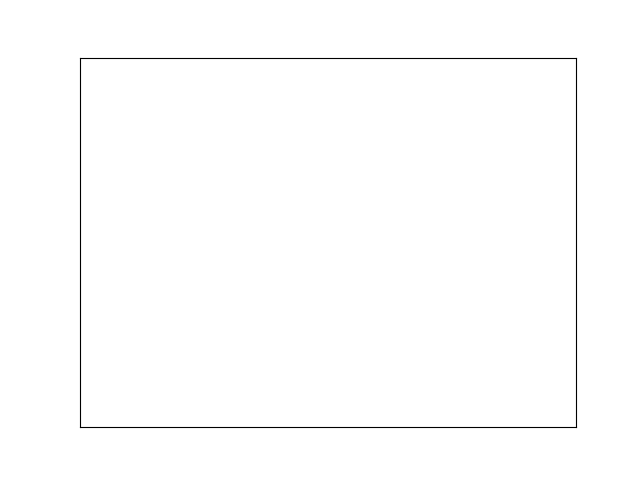

Text(value='', placeholder='Начало дуги')

Text(value='', placeholder='Конец дуги')

Text(value='', placeholder='Пропускная способность')

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [14]:
#### виджеты на добавление связи
start = widgets.Text(placeholder='Начало дуги',description='',disabled=False)
end = widgets.Text(placeholder='Конец дуги',description='',disabled=False)
cap = widgets.Text(placeholder='Пропускная способность',description='',disabled=False)
####
fig = plt.figure()
sub = fig.add_subplot()
if(len(list(C.nodes))>1):
    pos = nx.spring_layout(C)
    labels = nx.get_edge_attributes(C,'labels')
    nx.draw(C,pos,edge_color='black',width=1,linewidths=1,node_size=500,node_color='pink',alpha=0.9,labels={node:node for node in C.nodes()})
    nx.draw_networkx_edge_labels(C,pos,edge_labels=labels,font_color='black')
    plt.show()

def on_button_clicked():
    x = int(start.value)
    y = int(end.value)
    z = int(cap.value)
    if(x>0 and y>0 and z>0):
        sub.clear()
        start.value = ""
        end.value = ""
        cap.value = ""
        C.add_edge(x, y, labels="C: %i\n"%z, capacity=z)
        pos = nx.spring_layout(C)
        labels = nx.get_edge_attributes(C,'labels')
        nx.draw(C,pos,edge_color='black',width=1,linewidths=1,node_size=500,node_color='pink',alpha=0.9,labels={node:node for node in C.nodes()})
        nx.draw_networkx_edge_labels(C,pos,edge_labels=labels,font_color='black')
        print("Добавлено")
        plt.show()
    else:
        print("Число должно быть больше 0")
        
display(start,end,cap)    
im = widgets.interact_manual(on_button_clicked);
im.widget.children[0].description = 'Добавить'


In [35]:
print("Введите начальную и конечные вершины")
node_from = widgets.Text(placeholder='Из вершины',description='',disabled=False)
node_to = widgets.Text(placeholder='До вершины',description='',disabled=False)
global fr 
global to
fr = 0
to = 0
def on_path_clicked():
    global fr
    global to
    fr = int(node_from.value)
    to = int(node_to.value)
    if(fr>0 and to>0):
        node_from.value = ""
        node_to.value = ""
        print("Путь из вершины "+str(fr)+" в вершину "+str(to))
    else:
        print("Числа должны быть больше 0")

display(node_from,node_to)    
im = widgets.interact_manual(on_path_clicked);
im.widget.children[0].description = 'Задать вершины'



Введите начальную и конечные вершины


Text(value='', placeholder='Из вершины')

Text(value='', placeholder='До вершины')

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [36]:
listofpath = []
listofflow = []
flowlist = []
R.clear()

if(fr != 0 and to != 0):
    R = edmonds_karp2(C,fr,to)
else:
    print(fr,to)

In [37]:
flow = widgets.Text(placeholder='Максимальный поток',description='',disabled=False)

display(flow)
def flow_check():
    f = int(flow.value)
    if(f == R.graph['flow_value']):
        flow.layout.display = 'none'
        im.widget.children[0].layout.display = 'none'
        print("Поток найден верно")   

    
im = widgets.interact_manual(flow_check);

im.widget.children[0].description = 'Добавить'
im.widget.children[0].layout = Layout(width='30%')

Text(value='', placeholder='Максимальный поток')

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [39]:
print("Путь вводится через запятую: например: 1,2,5,7")
path = widgets.Text(placeholder='Путь',description='',disabled=False)
flow_for_path = widgets.Text(placeholder='Поток для этого пути',description='',disabled=False)
display(path,flow_for_path)

def path_check():
    p = path.value
    ffp = int(flow_for_path.value)
    p = list(map(int, p.split(',')))
    for i in range(len(listofpath)):
        if(p == listofpath[i] and ffp == flowlist[i]):
            print("Путь верный")
            
        else:
            print("Неверный путь")
            
im = widgets.interact_manual(path_check);

im.widget.children[0].description = 'Добавить'
im.widget.children[0].layout = Layout(width='30%')

Путь вводится через запятую: например: 1,2,5,7


Text(value='', placeholder='Путь')

Text(value='', placeholder='Поток для этого пути')

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [41]:
print("Введите ФИО, номер группы и код доступа")
name = widgets.Text(placeholder='ФИО',description='',disabled=False)
key = widgets.Text(placeholder='Код доступа',description='',disabled=False)
display(name,key)
def send_clicked():
    key_tmp = int(key.value)
    name_tmp = name.value
    if(key_tmp==1234):
        key.value = ""
        name.value = ""
        !jupyter nbconvert --config config.py 6_Maximum_flow.ipynb
        print("Данные отправлены! Спасибо!")
    else:
        print("Неверный код доступа")
    
im = widgets.interact_manual(send_clicked);
im.widget.children[0].description = 'Отправить'
im.widget.children[0].layout = Layout(width='30%')


Введите ФИО, номер группы и код доступа


Text(value='', placeholder='ФИО')

Text(value='', placeholder='Код доступа')

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…